In [1]:
import numpy as np
import pandas as pd
from river import optim
from river.drift import ADWIN
from ray.tune.search import BasicVariantGenerator
from sail.models.auto_ml.tune import SAILTuneGridSearchCV
from sail.models.river.forest import AdaptiveRandomForestClassifier
from sail.models.river.linear_model import LogisticRegression
from sail.models.auto_ml.auto_pipeline import SAILAutoPipeline
from sail.pipeline import SAILPipeline
from sklearn.impute import SimpleImputer
import ray.cloudpickle as cpickle
from sail.transfomers.river.preprocessing import StandardScaler

#### Load Data

In [2]:
df = pd.read_csv("../../datasets/agrawal.csv").head(50000)
X = df.copy()

y = X["class"]
X.drop("class", axis=1, inplace=True)


#### Model Definition

In [3]:
logistic_reg = LogisticRegression(optimizer=optim.SGD(0.1))
random_forest = AdaptiveRandomForestClassifier(n_models=10)

#### Create SAIL Pipeline

In [4]:
steps = [
    ("Imputer", SimpleImputer(missing_values=np.nan, strategy="mean")),
    ("standard_scalar", StandardScaler()),
    ("classifier", "passthrough"),
]
sail_pipeline = SAILPipeline(steps=steps)

[2023-06-15 22:32:14:380] - INFO - SAIL : created SAILPipeline object with ID 095a118b-e5dd-463a-ae72-6b4a473809ff


#### HPO Params

In [5]:
params_grid = [
    {
        "classifier": [logistic_reg],
        "classifier__l2": [0.1, 0.9],
        "classifier__intercept_init": [0.2, 0.5],
    },
    {
        "classifier": [random_forest],
        "classifier__n_models": [5, 10],
        "Imputer": ["passthrough"],
    },
]

# params_grid = {
#     "classifier__l2": [0.1, 0.9],
#     "classifier__intercept_init": [0.2, 0.5],
# }


#### Create Model Instance

In [6]:
auto_pipeline = SAILAutoPipeline(
    pipeline=sail_pipeline,
    pipeline_params_grid=params_grid,
    search_data_size=1000,
    search_method=SAILTuneGridSearchCV,
    search_method_params={
        "max_iters": 1,
        "early_stopping": False,
        "mode": "max",
        "scoring": "accuracy",
        "pipeline_auto_early_stop": False,
        "keep_best_configurations": 2
    },
    drift_detector=ADWIN(delta=0.001),
    pipeline_strategy="DetectAndIncrement",
)

[2023-06-15 22:32:14:392] - INFO - SAIL : Pipeline Strategy [DetectAndIncrement] created with actions: ['DATA_COLLECTION', 'FIND_BEST_PIPELINE', 'SCORE_AND_DETECT_DRIFT', 'PARTIAL_FIT_MODEL']


#### Start Training

In [7]:
y_preds = []
y_true = []
batch_size = 50

start = 0
for end in range(50, 2001, batch_size):

    X_train = X.iloc[start:end]
    y_train = y.iloc[start:end]

    if end > 1000: # search_data_size is 1000
        preds = auto_pipeline.predict(X_train)
        y_preds.extend(list(preds))
        y_true.extend(list(y_train))

    auto_pipeline.train(X_train, y_train)
    start = end


(_Trainable pid=58810) [2023-06-15 22:32:19:578] - INFO - SAIL : created SAILPipeline object with ID edc16510-b49d-445c-a969-558b28df9635
(_Trainable pid=58810) [2023-06-15 22:32:19:579] - INFO - SAIL : created SAILPipeline object with ID 79835f4e-fcea-43bc-8a45-d66401d9fa75
(_Trainable pid=58810) [2023-06-15 22:32:19:579] - INFO - SAIL : created SAILPipeline object with ID d49a1906-b216-4259-bdfe-e15c42f43abc
(_Trainable pid=58810) [2023-06-15 22:32:19:579] - INFO - SAIL : created SAILPipeline object with ID d94db043-61cc-4aa9-b542-d4b218ad59d7
(_Trainable pid=58810) [2023-06-15 22:32:19:580] - INFO - SAIL : created SAILPipeline object with ID 51ca22e3-89b1-44ca-9435-1f2bbf9b26b5
(_Trainable pid=58810) [2023-06-15 22:32:19:590] - INFO - SAIL : created SAILPipeline object with ID 796e1b1c-f669-4d47-a03e-f9fa2a25ef4c
(_Trainable pid=58810) [2023-06-15 22:32:19:612] - INFO - SAIL : created SAILPipeline object with ID fbb9d8a2-ef4d-4e79-a415-1960eeb22c93
(_Trainable pid=58810) [2023-06-15

(_Trainable pid=58810) [Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
(_Trainable pid=58810) [Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
(_Trainable pid=58810) [Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
(_Trainable pid=58810) [Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s
(_Trainable pid=58810) [Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.0s


2023-06-15 22:32:21,366	INFO tensorboardx.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'classifier': AdaptiveRandomForestClassifier()}
2023-06-15 22:32:22,774	INFO tensorboardx.py:269 -- Removed the following hyperparameter values when logging to tensorboard: {'classifier': AdaptiveRandomForestClassifier()}
[2023-06-15 22:32:22:804] - INFO - SAIL : created SAILPipeline object with ID 3e1dd911-3a2f-4189-b11e-bb81738224c2
[2023-06-15 22:32:22:806] - INFO - SAIL : created SAILPipeline object with ID a52f8a81-41c6-483a-b646-d5af255c79bb
[2023-06-15 22:32:23:562] - INFO - SAIL : Cumulative Pipeline Score: 0.88
[2023-06-15 22:32:23:577] - INFO - SAIL : Cumulative Pipeline Score: 0.91
[2023-06-15 22:32:23:593] - INFO - SAIL : Cumulative Pipeline Score: 0.8666666666666667
[2023-06-15 22:32:23:609] - INFO - SAIL : Cumulative Pipeline Score: 0.875
[2023-06-15 22:32:23:625] - INFO - SAIL : Cumulative Pipeline Score: 0.868
[2023-06-15 22:32:23:643] - INFO - S

[Pipeline] ........ (step 3 of 3) Processing classifier, total=   0.7s


[2023-06-15 22:32:23:767] - INFO - SAIL : Cumulative Pipeline Score: 0.8630769230769231
[2023-06-15 22:32:23:787] - INFO - SAIL : Cumulative Pipeline Score: 0.8657142857142858
[2023-06-15 22:32:23:803] - INFO - SAIL : Cumulative Pipeline Score: 0.8693333333333333
[2023-06-15 22:32:23:820] - INFO - SAIL : Cumulative Pipeline Score: 0.86375
[2023-06-15 22:32:23:836] - INFO - SAIL : Cumulative Pipeline Score: 0.8647058823529412
[2023-06-15 22:32:23:852] - INFO - SAIL : Cumulative Pipeline Score: 0.8677777777777778
[2023-06-15 22:32:23:868] - INFO - SAIL : Cumulative Pipeline Score: 0.8652631578947368
[2023-06-15 22:32:23:888] - INFO - SAIL : Cumulative Pipeline Score: 0.868


In [8]:
from sklearn.metrics import confusion_matrix, classification_report

print(classification_report(y_true, y_preds))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       652
           1       0.93      0.67      0.78       348

    accuracy                           0.87      1000
   macro avg       0.89      0.82      0.84      1000
weighted avg       0.88      0.87      0.86      1000



<Axes: >

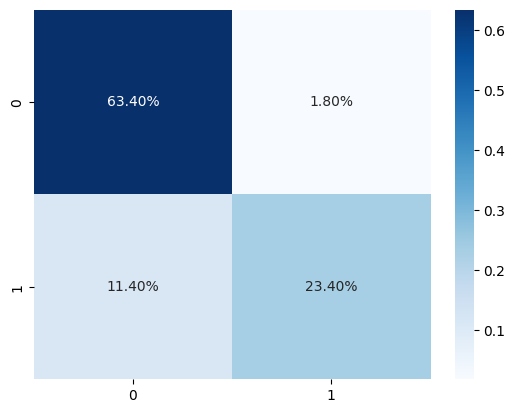

In [9]:
import seaborn as sns

cf_matrix = confusion_matrix(y_true, y_preds)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')